In [198]:
# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.optimizers import SGD,RMSprop,adam
import numpy as np
from pandas import DataFrame
from pandas import concat
from keras.layers import Dropout
from sklearn import svm
from sklearn.svm import SVR
import matplotlib.pyplot as plt

data_path = 'C:/Users/PagolPoka/Desktop/AGT_Task/task/data/ml_01_data.csv'

In [63]:
# load the new file
dataset = read_csv(data_path, header=0, infer_datetime_format=True)
print("Dataset: ")
print(dataset.columns)

Dataset: 
Index(['Year', 'Name', 'Number of visitors (all days combined)'], dtype='object')


In [68]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [71]:

X_Train = dataset.drop(['Year','Name'], axis=1)

print("Train data shape: ", X_Train.shape)

Superviseddata = series_to_supervised(X_Train)
print("Superviseddata: ")
print(Superviseddata)




Train data shape:  (25, 1)
Superviseddata: 
    var1(t-1)  var1(t)
1     43000.0   143000
2    143000.0   173000
3    173000.0   206000
4    206000.0   260000
5    260000.0   268000
6    268000.0   297000
7    297000.0   324000
8    324000.0   365000
9    365000.0   355000
10   355000.0   361000
11   361000.0   369000
12   369000.0   385000
13   385000.0   385000
14   385000.0   371000
15   371000.0   385000
16   385000.0   390000
17   390000.0   382000
18   382000.0   385000
19   385000.0   379000
20   379000.0   362000
21   362000.0   415000
22   415000.0   441000
23   441000.0   496000
24   496000.0   452000


In [212]:
#**************Reshaping the Data for the Deep Learning model. LSTM expects a tesor of shape : [DataSample, TimeSteps, Features]*************
sequences = 1 #Lenght of each timestep
result = []
result_y =[]


X_Train = Superviseddata.drop(['var1(t)'], axis=1)
Y_Train = Superviseddata.drop(['var1(t-1)'], axis=1)




# for loop will walk for each of the total rows
for i in range(0,len(X_Train)):
    # every group must have the same length, so if current loop position i + number 
    # of sequences is higher than df length, breaks
    if i+sequences <= len(X_Train):
        # this will add into the list as [[R1a,R1b...R1t],[R2a,R2b...R2t],...[R5a,R5b...R5t]]
        result.append(X_Train[i:i+sequences].values)     

# Converting to array + keras takes float32 better than 64
train_x = np.array(result).astype('float32')


train_y = Y_Train

print("Train data shape: ", train_x.shape)
print("Train data shape: ", train_y.shape)




Train data shape:  (24, 1, 1)
Train data shape:  (24, 1)


In [137]:
# train the model
def build_model(train_x, train_y, n_input):
    
# define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    print(n_timesteps)
    print(n_features)
    print(n_outputs)
    # define model
    model = Sequential()
    model.add(LSTM(20, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    
    model.summary()
    model.fit(train_x, train_y, epochs=1200, batch_size=batch_size, verbose=verbose)
    return model

In [152]:
# Design a LSTM model for training the multivariate timeseries data.
def build_model1(train_x, train_y, n_input):
    
# define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    learning_rate = 0.01

    Adam = adam(lr= learning_rate)
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(32, input_shape=(n_timesteps, n_features)))
    model_LSTM.add(Dropout(0.5))
    model_LSTM.add(Dense(100, activation='relu'))
    model_LSTM.add(Dense(n_outputs,activation='softmax'))
    model_LSTM.compile(loss='mse', optimizer=Adam,metrics=['accuracy'])

    model_LSTM.summary()
    model_LSTM.fit(train_x, train_y, epochs=100, batch_size=batch_size, verbose=verbose)
    return model

In [153]:
model = build_model1(train_x, train_y, 1)
# fit network


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 101       
Total params: 7,753
Trainable params: 7,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
24/24 [==============================] - 3s 130ms/step - loss: 127975598762.6667 - acc: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 0s 213us/step - loss: 127975604224.0000 - acc: 0.0000e+00
Epoch 3/100
24/24 [==============================]

In [213]:
# Fit regression model
svr_rbf = SVR(kernel='linear', C=100, gamma=0.1, epsilon=.1)

In [214]:
y_rbf = svr_rbf.fit(X_Train, Y_Train)

C:\Users\PagolPoka\Anaconda3\lib\site-packages\sklearn\svm\base.py:216: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64)


In [215]:
print(y_rbf)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [249]:
attendence = 452000
print(attendence)

452000


In [273]:
Year = []
Attendence = []
for year in range(1993,2026):
    Year.append(year)
print(Year)

crowd = dataset.drop(['Year','Name'], axis=1)
for i in crowd.values:
    Attendence.append(i)

print(len(Attendence))

[1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
25


In [274]:
attendence = 452000

for year in range(2018,2026):
    x = y_rbf.predict(attendence)
    print(year,x)
    Attendence.append(x)
    attendence = x

2018 [582290.67686585]
2019 [562960.29405335]
2020 [565828.21592835]
2021 [565402.71592835]
2022 [565465.85655335]
2023 [565456.48155335]
2024 [565457.87217835]
2025 [565457.66905335]


C:\Users\PagolPoka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\PagolPoka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\PagolPoka\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  Deprec

In [275]:
print(len(Attendence))

33


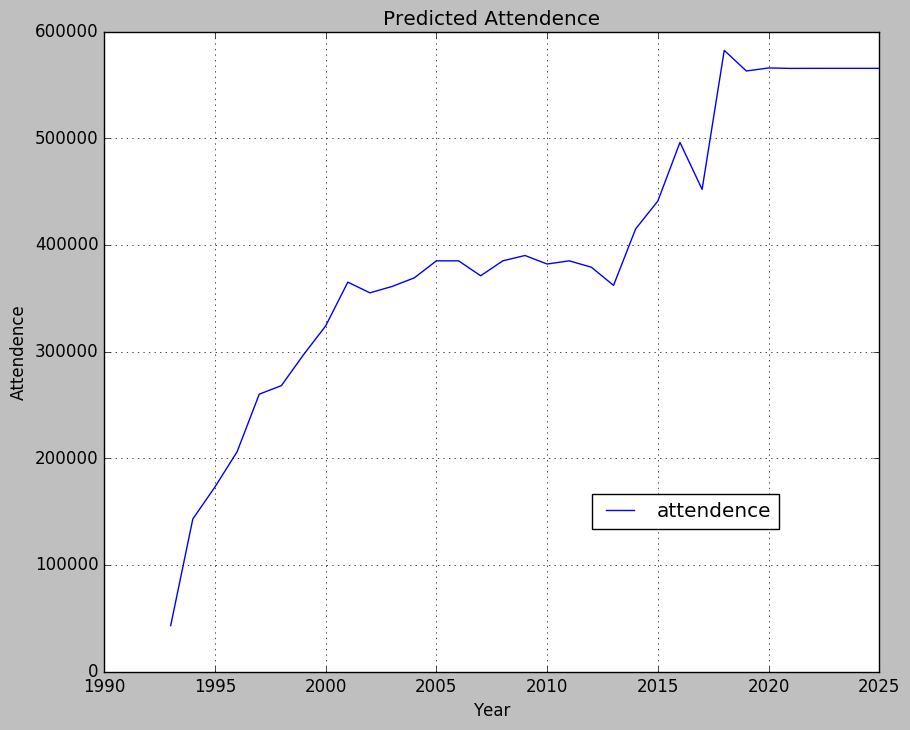

In [279]:
xc=Year

plt.figure(1,figsize=(10,8))
plt.plot(xc,Attendence)
plt.xlabel('Year')
plt.ylabel('Attendence')
plt.title('Predicted Attendence')
plt.grid(True)
plt.legend(['attendence'], loc=10, bbox_to_anchor=(0.5, 0., 0.5, 0.5))
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.show()